Descomprimimos el archivo zip que contiene los datasets

Si estamos utilizando google colab en vez de clonar el repositorio con wget obtenemos el zip que contiene los datasets:

In [110]:
import os

zip_filename = 'Recursos Lab3.zip'
url = 'https://github.com/Alf-caput/LAB03_Clasificacion/raw/main/Recursos%20Lab3.zip'

if not os.path.exists(zip_filename):
    os.system('wget' + ' ' + url)

In [111]:
from zipfile import ZipFile
import os

zip_filename = 'Recursos Lab3.zip'
base_dir = os.path.splitext(zip_filename)[0] + '/'

if not os.path.exists(base_dir):
    with ZipFile(zip_filename, 'r') as zf:
        for file in zf.namelist():
            if file.startswith(base_dir):
                zf.extract(file)

# PRÁCTICA 3: DETECCIÓN DE MALWARE

Descomprimimos la carpeta comprimida Malware.zip

In [112]:
import os
import zipfile

zip_filename = 'Malware.zip'
output_dir = os.path.splitext(zip_filename)[0] + '/'
output_dir = os.path.join(base_dir, output_dir)

if not os.path.exists(output_dir):
    with zipfile.ZipFile(os.path.join(base_dir, zip_filename)) as zf:
        zf.extractall(path=base_dir)

Con opencv-python convertimos las imágenes a numpy arrays.  
Para almacenar las imágenes creamos un diccionario que lleva por claves las 4 posibles clases y como valores listas que contienen los numpy arrays.

Adicionalmente comprobamos los tamaños de las imágenes, nadie nos garantiza que todas o dentro de cada carpeta se tenga un único tamaño.  
Utilizamos set() para detectar los diferentes tamaños únicos existentes.

In [113]:
import cv2

labels = os.listdir(output_dir)
data = dict()
shapes = dict()

for label in labels:

    class_dir = os.path.join(output_dir, label)

    data[label] = []
    shapes[label] = []

    for image in os.listdir(class_dir):

        image = cv2.imread(os.path.join(class_dir, image), cv2.IMREAD_GRAYSCALE)

        data[label].append(image)
        shapes[label].append(image.shape)

    shapes[label] = list(set(shapes[label]))

data[labels[0]][0], shapes[labels[0]]

(array([[ 77,  90, 144, ...,   0,   0,   0],
        [  0,   0,   0, ...,  85,  70,   0],
        [ 80, 255,  21, ...,   0,  80, 232],
        ...,
        [226,  75, 188, ...,  20, 178,  68],
        [222,  80, 215, ...,  91, 105,  71],
        [  5, 139, 164, ...,  67, 253,  66]], dtype=uint8),
 [(683, 768)])

Se observa que tienen dimensiones distintas, tanto fuera como dentro de una misma clase, tomaremos como dimensiones estándar las menores existentes (de manera independiente la menor X y la menor Y)

In [114]:
min_dim = dict()
for label in labels:
    min_dim[label] = shapes[label][0]  # start with shape[0] as min
    for shape in shapes[label][1:]:
        min_dim[label] = min(min_dim[label][0], shape[0]), min(min_dim[label][1], shape[1])

std_dim = min(min_dim.values())
std_dim

(208, 64)

A continuación, se redimensionan las imágenes a la dimensión estándar

In [115]:
for label in labels:
    for i, image in enumerate(data[label]):
        data[label][i] = cv2.resize(image, std_dim[::-1]) # due to cv2.resize use (width, height) we reverse dimensions

Podemos comprobar que la redimensión ha tenido éxito stackeando los numpy arrays por etiqueta, que además es un formato más conveniente cuando se trabaja con tensores

In [116]:
import numpy as np
from copy import deepcopy

ds = deepcopy(data)

for label in labels:
    ds[label] = np.stack(data[label])
    print(label, ds[label].shape)

Yuner.A (173, 208, 64)
Fakerean (59, 208, 64)
Lolyda.AA1 (167, 208, 64)
Agent.FYI (66, 208, 64)


Podemos ver un ejemplo de cada clase

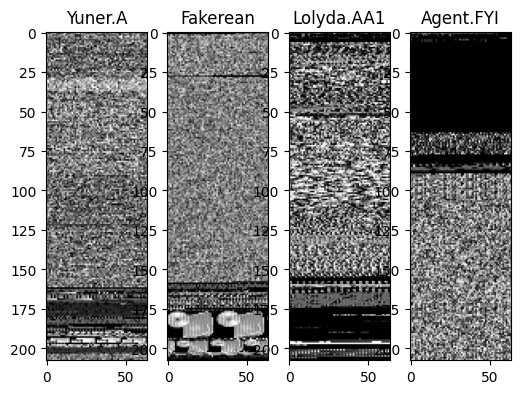

In [117]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(6, 6))

for idx, label in enumerate(data):
    axs[idx].imshow(ds[label][0], cmap='gray')
    axs[idx].set_title(label)

plt.show()

Definimos dos tensores:  
- Imágenes (X)
- Etiquetas (y)

In [118]:
import numpy as np

X = np.array([x for label in labels for x in ds[label]])
y = np.array([labels.index(label) for label in labels for idx in range(len(ds[label]))])

X.shape, y.shape

((465, 208, 64), (465,))

En total contamos con 465 imágenes de dimensiones (height, width) = (208, 64) y 465 etiquetas de dimensión ()

### 1) Crea un clasificador, realiza al menos tres configuraciones y dibuja una tabla donde se muestre la precisión  con  la  que  clasifican.  ¿Cómo  funcionaría  si  no  usamos  kernels?  ¿Y  al  usar  distintos kernels?

Dividimos en datos de train y test, adicionalmente utilizamos namedtuples por legibilidad.   
Nota: Reservamos 10 imágenes para el segundo apartado del ejercicio.

In [119]:
seed = 42
n = 10
np.random.seed(seed=seed)
random_10_index = np.random.choice(X.shape[0], n, replace=False)

X_10 = X[random_10_index, :, :]
X = np.delete(X, random_10_index, axis=0)

y_10 = y[random_10_index]
y = np.delete(y, random_10_index, axis=0)

X.shape, y.shape

((455, 208, 64), (455,))

In [120]:
from sklearn.model_selection import train_test_split
from collections import namedtuple

seed = 42
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_ratio, shuffle=True)

Dataset = namedtuple('Dataset', ['X', 'y'])

ds_train = Dataset(X_train, y_train)
ds_test = Dataset(X_test, y_test)

print("Train:", ds_train.X.shape, ds_train.y.shape)
print("Test:", ds_test.X.shape, ds_test.y.shape)

Train: (364, 208, 64) (364,)
Test: (91, 208, 64) (91,)


In [121]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from functools import partial
from sklearn.preprocessing import FunctionTransformer

flatten = lambda x: np.reshape(x, newshape=(x.shape[0], -1))
flatten = FunctionTransformer(flatten)

clf = make_pipeline(flatten, StandardScaler(), SVC(gamma='auto'))
clf.fit(ds_train.X, ds_train.y)

y_pred = clf.predict(ds_test.X)
y_pred

array([2, 0, 3, 3, 0, 2, 2, 0, 3, 0, 0, 1, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0,
       2, 0, 2, 1, 0, 3, 0, 2, 2, 2, 3, 0, 3, 0, 2, 2, 0, 0, 2, 0, 3, 0,
       0, 0, 0, 2, 3, 2, 2, 0, 2, 3, 0, 2, 0, 3, 0, 3, 1, 0, 0, 2, 2, 0,
       3, 2, 2, 1, 3, 2, 0, 1, 2, 3, 0, 2, 3, 0, 1, 2, 2, 0, 0, 3, 3, 0,
       0, 0, 0])

In [122]:
from sklearn.metrics import accuracy_score

y_true = ds_test.y
accuracy_score(y_true, y_pred)

1.0

El modelo parece funcionar, probamos ahora 3 configuraciones distintas:

In [123]:
from sklearn.metrics import accuracy_score
configs = [
    {'kernel': 'poly'},
    {'kernel': 'linear'},
    {'kernel': 'rbf'},
    ]

classifiers = list()
y_preds = dict()
for cfg in configs:
  clf = make_pipeline(flatten, StandardScaler(), SVC(gamma='auto', **cfg))
  clf.fit(ds_train.X, ds_train.y)
  classifiers.append(clf)
  y_preds[cfg['kernel']] = clf.predict(ds_test.X)

y_true = ds_test.y
print('--------------------------')
print('Resultados')
print('--------------------------')
for cfg, y_pred in y_preds.items():
  print(cfg, '\t', accuracy_score(y_true, y_pred))

--------------------------
Resultados
--------------------------
poly 	 0.967032967032967
linear 	 1.0
rbf 	 1.0


Como resultados obtenemos que los modelos de kernel **lineal** y **rbf** aciertan todas las imágenes de test, mientras que el modelo de kernel **poly** acierta el 96.70%.

### 2) Elige 10 imágenes que no hayas usado ni para entrenar el modelo, ni para evaluarlo y clasifícalas. Usa para ello el modelo que mejor clasifique de los del punto anterior. Índica con que error o acierto ha funcionado el clasificador. (1 punto)

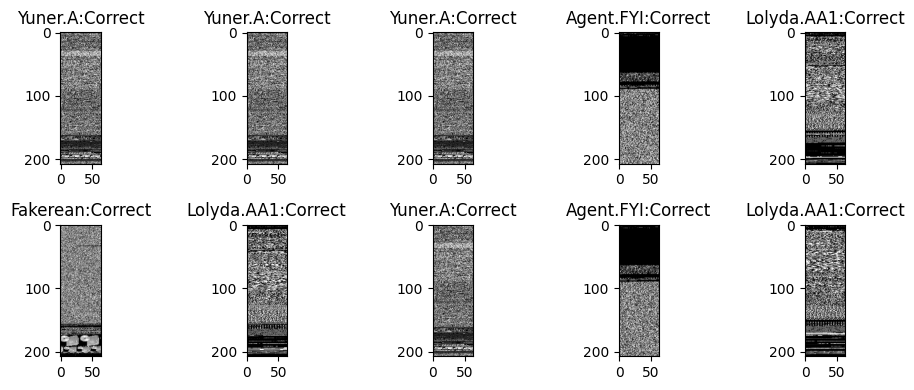

In [128]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
y_pred = classifiers[2].predict(X_10)

for i, ax in enumerate(axs.flat):
  ax.imshow(X_10[i], cmap='gray')

  label = labels[y_10[i]]
  if y_pred[i] == y_10[i]:
    msg = 'Correct'
  else:
    msg = 'Incorrect'

  ax.set_title(label + ':' + msg)

plt.tight_layout()

plt.show()

In [129]:
print('--------------------------')
print('Resultados')
print('--------------------------')
print('rbf', '\t', accuracy_score(y_10, y_pred))

--------------------------
Resultados
--------------------------
rbf 	 1.0


Como resultado se ha obtenido que el modelo acierta las 10 imágenes aleatorias que hemos elegido y que no formaban parte del entrenamiento o la evaluación.

# PRÁCTICA 4: DIAGNÓSTICO DE CÁNCER CON GÉNES

### Importación de las librerías necesarias

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### Carga de la base de datos

In [ ]:
df = pd.read_csv("Recursos Lab3/genes.csv")
df.head()

,Gene1,Gene2,CancerPresent
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


### Apartado 1
Creación de un set de entrenamiento, otro de validación y uno de test.
Para ello, primero vamos a dividir el dataset en dos:
 - X: Características de las observaciones
 - y: Etiquetas de los datos

In [ ]:
X = df[['Gene1', 'Gene2']]
y = df['CancerPresent']

Vamos a visualizar como se comportan los datos del DataFrame:

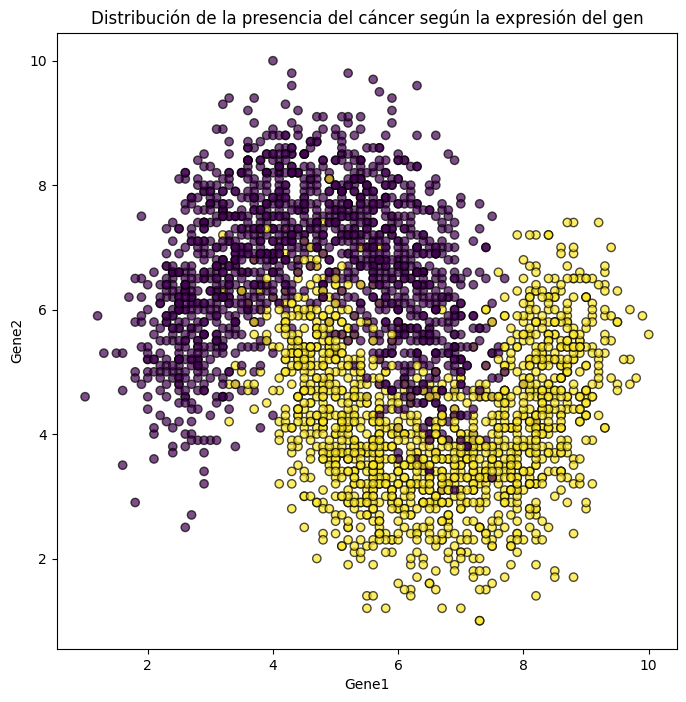

In [ ]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X['Gene1'], X['Gene2'], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.xlabel('Gene1')
plt.ylabel('Gene2')
plt.title('Distribución de la presencia del cáncer según la expresión del gen')
plt.grid(False)
plt.show()

<div style="text-align: justify">
Parece que los datos están algo mezclados, con algunas áreas donde los puntos morados y amarillos se superponen, dichas áreas van a provocar problemas en la clasificación. Sin embargo, hay regiones donde se podría trazar una línea o curva que separara en gran medida los dos conjuntos.
</div>

<div style="text-align: justify">
A continuación, dividimos los datos en conjuntos de entrenamiento y prueba. Dentro de los datos de entrenamiento, realizamos una segunda partición para crear datos de validación:
</div>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 
X_train.shape, y_train.shape, X_val.shape,y_val.shape, X_test.shape, y_test.shape

((1800, 2), (1800,), (600, 2), (600,), (600, 2), (600,))

### Apartados 2 y 3

A continuación, se normalizan los datos para facilitar la convergencia del algoritmo y reducir la complejidad del cómputo:

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

A continuación, se empleará el algoritmo de los K-vecinos. Dicho algoritmo acepta dos parámetros: el número K de vecinos cercanos y la métrica de distancia escogida. La función lo realiza de forma bruta con las distancias euclídea y de Manhattan. Además, solo emplea números impares para K con el fin de evitar empates en la elección de clase y $K \leq \sqrt{N}$ donde N es el número de observaciones de training:

In [ ]:
def evaluate_knn(k_values, distance_metrics, X_train, y_train, X_val, y_val):
    results = []
    for k in k_values:
        for distance in distance_metrics:
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)

            results.append({
                'k': k,
                'distance_metric': distance,
                'accuracy': accuracy
            })
    return pd.DataFrame(results)

k_values = range(1, round(math.sqrt(len(X_train))), 2)
distance_metrics = ['euclidean', 'manhattan']
knn_results = evaluate_knn(k_values, distance_metrics, X_train_scaled, y_train, X_val_scaled, y_val)
knn_results.sort_values(by='accuracy', ascending=False).head()

,k,distance_metric,accuracy
24,25,euclidean,0.945000
22,23,euclidean,0.943333
20,21,euclidean,0.943333
19,19,manhattan,0.943333
18,19,euclidean,0.943333



Podemos observar en la tabla que la configuración con K = 25 y distancia euclidiana tiene la mayor precisión en los datos de validación, con una puntuación del 94.5%.

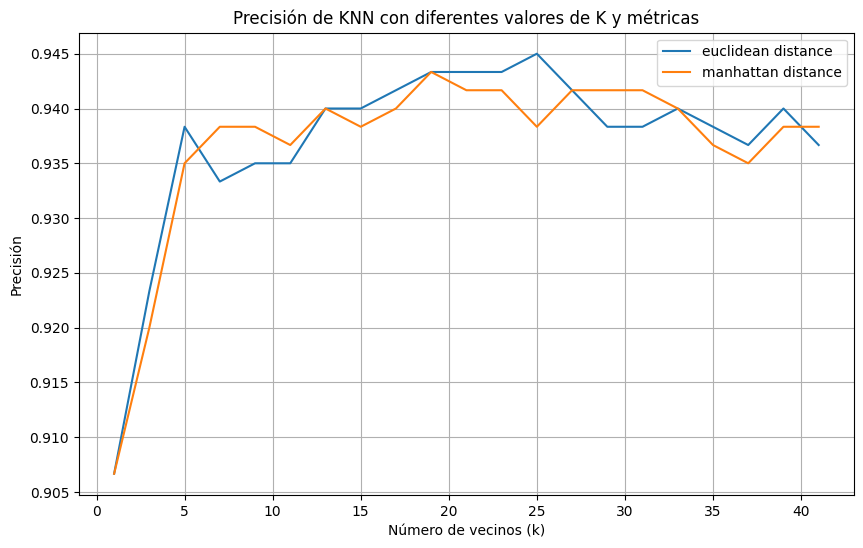

In [ ]:
plt.figure(figsize=(10, 6))
for distance in distance_metrics:
    subset = knn_results[knn_results['distance_metric'] == distance]
    plt.plot(subset['k'], subset['accuracy'], label=f'{distance} distance')

plt.title('Precisión de KNN con diferentes valores de K y métricas')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

<div style="text-align: justify">
En la gráfica se observa que para valores bajos de K, la precisión aumenta rápidamente, lo que sugiere que un número pequeño de vecinos cercanos es suficiente para hacer una buena clasificación en este caso. A medida que k aumenta, la precisión parece estabilizarse y fluctúa ligeramente sin una tendencia clara a la baja o al alza, lo que puede indicar que agregar más vecinos no mejora significativamente la precisión del modelo.

Ambas métricas de distancia muestran un comportamiento similar en términos de precisión a lo largo de diferentes valores de k.
</div>

/tmp/ipykernel_610/1595385808.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


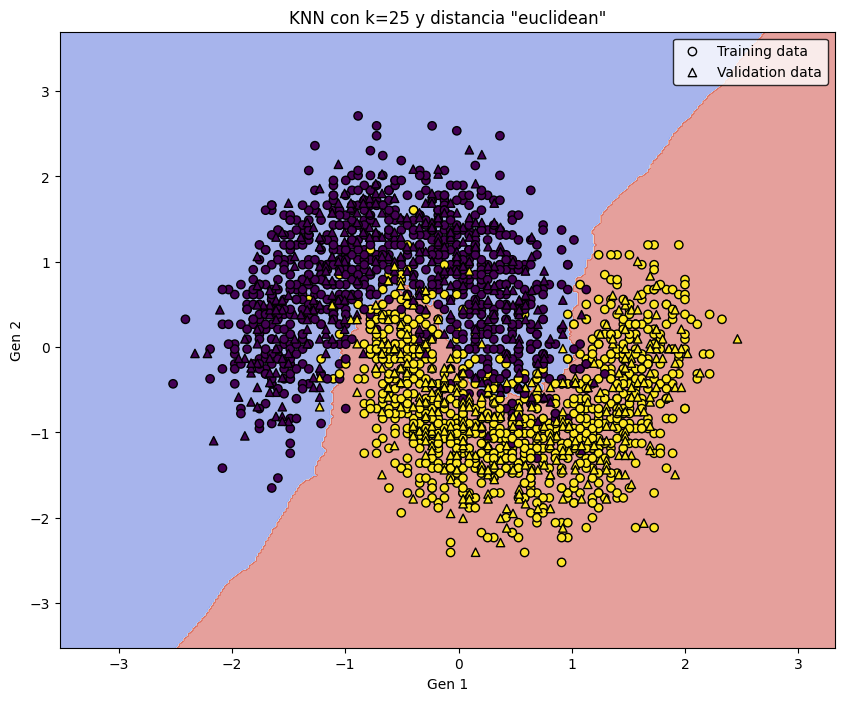

In [ ]:
best_model_data = knn_results.sort_values(by='accuracy', ascending=False).iloc[0]
best_knn = KNeighborsClassifier(n_neighbors=best_model_data['k'], metric=best_model_data['distance_metric'])
best_knn.fit(X_train_scaled, y_train)

h = .02 
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = best_knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, marker='o', label='Training data', edgecolors='k')
plt.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], c=y_val, marker='^', label='Validation data', edgecolors='k')
plt.xlabel('Gen 1')
plt.ylabel('Gen 2')
plt.title(f'KNN con k={best_model_data["k"]} y distancia "{best_model_data["distance_metric"]}"')

legend = plt.legend(edgecolor='black')
for handle in legend.legendHandles:
    handle.set_facecolor("none")

<div style="text-align: justify">
Podemos observar que, efectivamente, como se mencionó anteriormente, las áreas donde se superponen ambas categorías iban a ser problemáticas. No obstante, en general ha logrado clasificar correctamente ambas clases.
</div>

### Apartado 4

Creamos un nuevo .csv con los datos de test:

In [ ]:
df_X = pd.DataFrame(X_test_scaled, columns=['Gene1', 'Gene2'])
df_y = pd.DataFrame(y_test, columns=['CancerPresent'])
df_y = df_y.reset_index()
df_pacientes_test = pd.concat([df_X, df_y], axis=1)
df_pacientes_test.to_csv('pacientes_test.csv', index=False)

Leemos el .csv recien generado y lo separamos en características y etiquetas:

In [ ]:
df_test = pd.read_csv('pacientes_test.csv')
X_test = df_test[['Gene1', 'Gene2']]
y_test = df_test['CancerPresent']

Hacemos predicciones:

In [ ]:
y_pred = best_knn.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f'La precisión del modelo en los datos de test es: {test_accuracy}')

La precisión del modelo en los datos de test es: 0.9316666666666666


/home/vscode/.local/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


El modelo tiene una precisión del 93.16% con los datos de test, por tanto, se trata de un modelo bastante preciso.

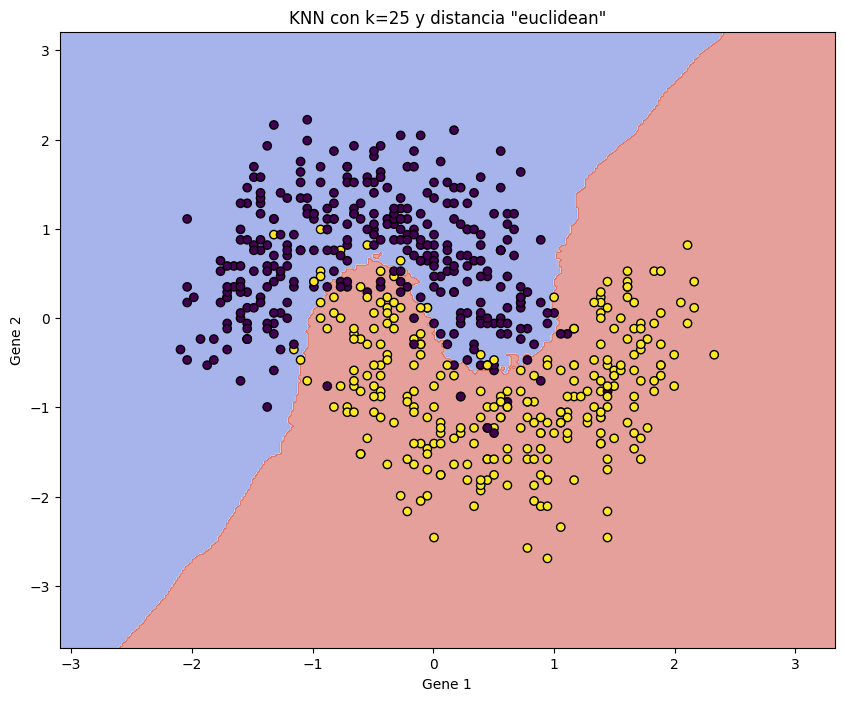

In [ ]:
h = .02 
x_min, x_max = X_test['Gene1'].min() - 1, X_test['Gene1'].max() + 1
y_min, y_max = X_test['Gene2'].min() - 1, X_test['Gene2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = best_knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(X_test['Gene1'], X_test['Gene2'], c=y_test, marker='o', edgecolors='k', label='Test data')
plt.xlabel('Gene 1')
plt.ylabel('Gene 2')
plt.title(f'KNN con k={best_model_data["k"]} y distancia "{best_model_data["distance_metric"]}"')
plt.show()